#<b><center>EDA review-Florida</b></center>

Importacion de librerías

In [1]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
from google.cloud import storage
import pyarrow.parquet as pq
from google.colab import auth
auth.authenticate_user()

Montando carpeta drive.

In [2]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/datalake/reviews-estados/review-Florida
archivos = os.listdir()
df = pd.DataFrame()
for archivo in archivos:
    if archivo.endswith('.json'):  # Puedes ajustar la extensión según tus necesidades
        print('Cargando data ',archivo,'...')
        data = pd.read_json(archivo, lines=True)
        #df.append(data)
        df = pd.concat([df, data], axis=0)


/content/drive/MyDrive/datalake/reviews-estados/review-Florida
Cargando data  11.json ...
Cargando data  14.json ...
Cargando data  13.json ...
Cargando data  10.json ...
Cargando data  12.json ...
Cargando data  1.json ...
Cargando data  15.json ...
Cargando data  16.json ...
Cargando data  17.json ...
Cargando data  18.json ...
Cargando data  19.json ...
Cargando data  2.json ...
Cargando data  3.json ...
Cargando data  4.json ...
Cargando data  5.json ...
Cargando data  8.json ...
Cargando data  6.json ...
Cargando data  7.json ...
Cargando data  9.json ...


Se verifica el tipo de variable de cada columna en caso sea necesario cambiarlo.

In [4]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2850000 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  float64
 1   name     object 
 2   time     int64  
 3   rating   int64  
 4   text     object 
 5   pics     object 
 6   resp     object 
 7   gmap_id  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 195.7+ MB


,user_id,name,time,rating,text,pics,resp,gmap_id
0,1.067380e+20,Electronic Fix,1562194780443,5,The chip and queso is the best,None,None,0x88c2c11c79cc1281:0x9a6589fa9704fc97
1,1.000709e+20,alicia zelada,1576580673464,5,Very good food,[{'url': ['https://lh5.googleusercontent.com/p...,None,0x88c2c11c79cc1281:0x9a6589fa9704fc97
2,1.138442e+20,Candice Casanova,1484274439363,5,I love tijuana flats. Always have always will,None,None,0x88c2c11c79cc1281:0x9a6589fa9704fc97
3,1.015351e+20,Tom Cardinale,1571629517479,5,Rays strike out 10 batters and lunch is on the...,None,None,0x88c2c11c79cc1281:0x9a6589fa9704fc97
4,1.127803e+20,Art Solanes,1341498334997,3,"Typical chain. In my opinion, find a local re...",None,None,0x88c2c11c79cc1281:0x9a6589fa9704fc97


In [5]:
tiempos = []
for data in df['time']/1000:
  tiempos.append(datetime.utcfromtimestamp(data).strftime('%d/%m/%Y %H:%M:%S'))

df['time_normalizado'] = tiempos

In [6]:
df.head()

,user_id,name,time,rating,text,pics,resp,gmap_id,time_normalizado
0,1.067380e+20,Electronic Fix,1562194780443,5,The chip and queso is the best,None,None,0x88c2c11c79cc1281:0x9a6589fa9704fc97,03/07/2019 22:59:40
1,1.000709e+20,alicia zelada,1576580673464,5,Very good food,[{'url': ['https://lh5.googleusercontent.com/p...,None,0x88c2c11c79cc1281:0x9a6589fa9704fc97,17/12/2019 11:04:33
2,1.138442e+20,Candice Casanova,1484274439363,5,I love tijuana flats. Always have always will,None,None,0x88c2c11c79cc1281:0x9a6589fa9704fc97,13/01/2017 02:27:19
3,1.015351e+20,Tom Cardinale,1571629517479,5,Rays strike out 10 batters and lunch is on the...,None,None,0x88c2c11c79cc1281:0x9a6589fa9704fc97,21/10/2019 03:45:17
4,1.127803e+20,Art Solanes,1341498334997,3,"Typical chain. In my opinion, find a local re...",None,None,0x88c2c11c79cc1281:0x9a6589fa9704fc97,05/07/2012 14:25:34


In [7]:
df['user_id'] = df['user_id'].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2850000 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   name              object
 2   time              int64 
 3   rating            int64 
 4   text              object
 5   pics              object
 6   resp              object
 7   gmap_id           object
 8   time_normalizado  object
dtypes: int64(2), object(7)
memory usage: 217.4+ MB


<b>Filtrado de columnas</b>

Se selecciona solo las columnas que pueden contener información relevante para el análisis.
- "pics" : no se realiza un análisis de imágenes
- "resp": son respuestas de los desarrolladores, generalmente de agredecimiento de los comentarios.

In [8]:
df_analisis = df[['user_id','name','time','time_normalizado','rating','text','gmap_id']]
df_analisis.head()

,user_id,name,time,time_normalizado,rating,text,gmap_id
0,106738031899982430208.0,Electronic Fix,1562194780443,03/07/2019 22:59:40,5,The chip and queso is the best,0x88c2c11c79cc1281:0x9a6589fa9704fc97
1,100070856359404142592.0,alicia zelada,1576580673464,17/12/2019 11:04:33,5,Very good food,0x88c2c11c79cc1281:0x9a6589fa9704fc97
2,113844240216197382144.0,Candice Casanova,1484274439363,13/01/2017 02:27:19,5,I love tijuana flats. Always have always will,0x88c2c11c79cc1281:0x9a6589fa9704fc97
3,101535107015468662784.0,Tom Cardinale,1571629517479,21/10/2019 03:45:17,5,Rays strike out 10 batters and lunch is on the...,0x88c2c11c79cc1281:0x9a6589fa9704fc97
4,112780340205315440640.0,Art Solanes,1341498334997,05/07/2012 14:25:34,3,"Typical chain. In my opinion, find a local re...",0x88c2c11c79cc1281:0x9a6589fa9704fc97


<b>Analizando las columnas numéricas</b>
- "time" se entiende como el número de registro.
- "rating" es la puntuación del usuario de 1 a 5, su variación se encuentra en ese rango

In [9]:
df_analisis.describe()

,time,rating
count,2.850000e+06,2.850000e+06
mean,1.555140e+12,4.313658e+00
std,4.360793e+10,1.170064e+00
min,1.041379e+12,1.000000e+00
25%,1.527462e+12,4.000000e+00
50%,1.557678e+12,5.000000e+00
75%,1.585605e+12,5.000000e+00
max,1.631205e+12,5.000000e+00


<b>Filtros complementarios</b>

Posibles duplicados y nulos. El uso de memoria se reduce a 75.8 Mb

In [10]:
df_analisis.dropna(inplace=True)
df_analisis.drop_duplicates(inplace=True)
df_analisis.reset_index(drop=True,inplace=True)
df_analisis.info()
df_analisis.head(5)

<ipython-input-10-d87d968368bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis.dropna(inplace=True)
<ipython-input-10-d87d968368bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656239 entries, 0 to 1656238
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   user_id           1656239 non-null  object
 1   name              1656239 non-null  object
 2   time              1656239 non-null  int64 
 3   time_normalizado  1656239 non-null  object
 4   rating            1656239 non-null  int64 
 5   text              1656239 non-null  object
 6   gmap_id           1656239 non-null  object
dtypes: int64(2), object(5)
memory usage: 88.5+ MB


,user_id,name,time,time_normalizado,rating,text,gmap_id
0,106738031899982430208.0,Electronic Fix,1562194780443,03/07/2019 22:59:40,5,The chip and queso is the best,0x88c2c11c79cc1281:0x9a6589fa9704fc97
1,100070856359404142592.0,alicia zelada,1576580673464,17/12/2019 11:04:33,5,Very good food,0x88c2c11c79cc1281:0x9a6589fa9704fc97
2,113844240216197382144.0,Candice Casanova,1484274439363,13/01/2017 02:27:19,5,I love tijuana flats. Always have always will,0x88c2c11c79cc1281:0x9a6589fa9704fc97
3,101535107015468662784.0,Tom Cardinale,1571629517479,21/10/2019 03:45:17,5,Rays strike out 10 batters and lunch is on the...,0x88c2c11c79cc1281:0x9a6589fa9704fc97
4,112780340205315440640.0,Art Solanes,1341498334997,05/07/2012 14:25:34,3,"Typical chain. In my opinion, find a local re...",0x88c2c11c79cc1281:0x9a6589fa9704fc97


La media indica un valor de 4.28 puntos, lo que habla muy bien de los locales en Florida con 1.6 millones de reviews de respaldo.

In [11]:
df_analisis.describe()

,time,rating
count,1.656239e+06,1.656239e+06
mean,1.553962e+12,4.282500e+00
std,4.570962e+10,1.260143e+00
min,1.041379e+12,1.000000e+00
25%,1.525315e+12,4.000000e+00
50%,1.556821e+12,5.000000e+00
75%,1.590434e+12,5.000000e+00
max,1.631153e+12,5.000000e+00


<b>Pairplot</b>

Como era de suponerse, la puntuación es discreta entre 1 y 5. En el gráfico "rating" vs "time" se observa que los primeros reviews fueron pocos y con una tendencia entre 3 o 4 puntos; sin embargo, el gráfico no ayuda a distinguir las siguientes puntuaciones.

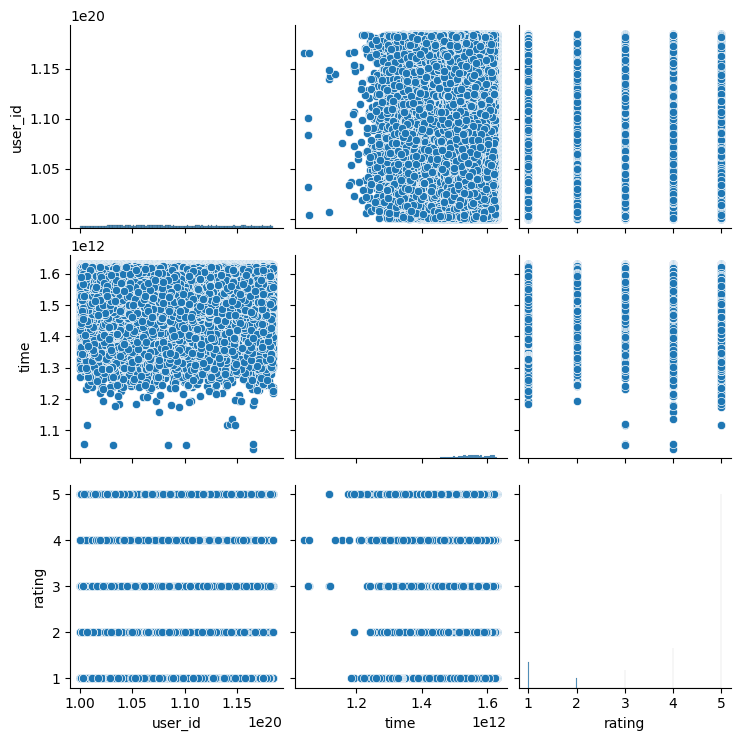

In [12]:
sns.pairplot(df_analisis)

Del pairplot se aprecian outliers de la columna 'time', por cual se realiza un análisis de la columna para eliminar valores atípicos

Text(0.5, 0, 'Tiempo de registro')

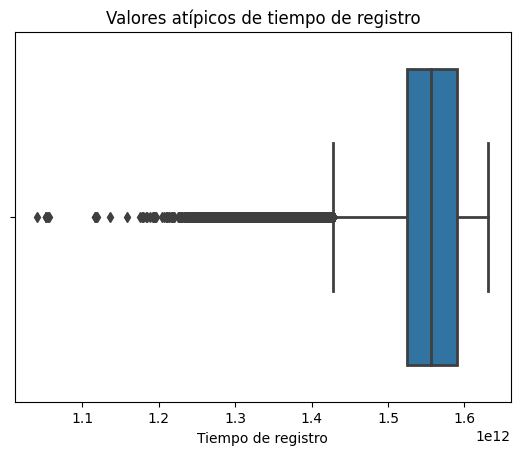

In [13]:
ax = sns.boxplot( x ="time",data = df_analisis, linewidth = 2)

ax.set_title('Valores atípicos de tiempo de registro')
ax.set_xlabel('Tiempo de registro')

Se extraen los valores atípicos. Con 3 desviaciones estándar se aseguro solo descartar los valores atípicos.




In [14]:
z_scores = zscore(df_analisis['time'])
abs_z_scores = np.abs(z_scores)

# Select the outliers using a threshold of 3
outliers = df_analisis[abs_z_scores > 3]
df_analisis = df_analisis[abs_z_scores <= 3]
outliers.head()
outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13182 entries, 4 to 1655984
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           13182 non-null  object
 1   name              13182 non-null  object
 2   time              13182 non-null  int64 
 3   time_normalizado  13182 non-null  object
 4   rating            13182 non-null  int64 
 5   text              13182 non-null  object
 6   gmap_id           13182 non-null  object
dtypes: int64(2), object(5)
memory usage: 823.9+ KB


In [15]:
df_analisis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643057 entries, 0 to 1656238
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   user_id           1643057 non-null  object
 1   name              1643057 non-null  object
 2   time              1643057 non-null  int64 
 3   time_normalizado  1643057 non-null  object
 4   rating            1643057 non-null  int64 
 5   text              1643057 non-null  object
 6   gmap_id           1643057 non-null  object
dtypes: int64(2), object(5)
memory usage: 100.3+ MB


In [16]:
ratings_count = df_analisis[['rating','user_id']].groupby(by='rating', as_index=False).count().sort_values(by='rating', ascending=True)
ratings_count

,rating,user_id
0,1,144557
1,2,54259
2,3,103091
3,4,228337
4,5,1112813


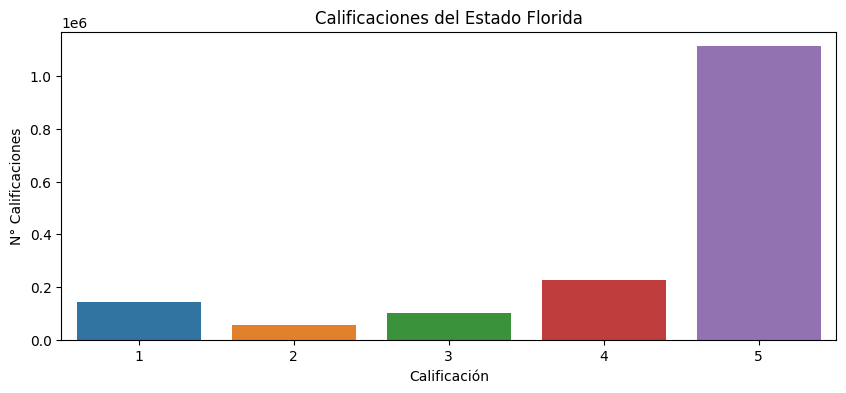

In [17]:
plt.figure(figsize=(10,4), dpi=100)
sns.barplot(data=ratings_count, x='rating', y='user_id')
plt.xlabel('Calificación')
plt.ylabel('N° Calificaciones')
plt.title("Calificaciones del Estado Florida")

plt.show()

Dividiendo en dataframes más pequeños y guardando lo obtenido:



In [18]:
users = df_analisis[['user_id','name']]
users.drop_duplicates(inplace=True)
users.reset_index(drop=True,inplace=True)
users.info()

<ipython-input-18-399b2f488d99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671732 entries, 0 to 671731
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  671732 non-null  object
 1   name     671732 non-null  object
dtypes: object(2)
memory usage: 10.2+ MB


In [19]:
ratings = df_analisis[['user_id','time_normalizado','gmap_id','rating']]
ratings.drop_duplicates(inplace=True)
ratings.reset_index(drop=True,inplace=True)
ratings.info()

<ipython-input-19-498044b1583f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642943 entries, 0 to 1642942
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   user_id           1642943 non-null  object
 1   time_normalizado  1642943 non-null  object
 2   gmap_id           1642943 non-null  object
 3   rating            1642943 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 50.1+ MB


In [20]:
reviews = df_analisis[['user_id','time_normalizado','gmap_id','text']]
reviews.drop_duplicates(inplace=True)
reviews.reset_index(drop=True,inplace=True)
reviews.info()

<ipython-input-20-4a0e2628c92b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642943 entries, 0 to 1642942
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   user_id           1642943 non-null  object
 1   time_normalizado  1642943 non-null  object
 2   gmap_id           1642943 non-null  object
 3   text              1642943 non-null  object
dtypes: object(4)
memory usage: 50.1+ MB


Guardado en carpeta local de Google Drive:

In [21]:
users.to_parquet('users.parquet')
ratings.to_parquet('ratings.parquet')
reviews.to_parquet('reviews.parquet')

Guardado en datalake de Google Storage:

In [22]:
project_id = 'deep-wave-407518'
bucket_name = 'yelp-and-maps-data-processed'


In [23]:
# Google Storage user.parquet
# Configura el cliente de almacenamiento
client = storage.Client(project=project_id)

# Obtén el bucket
bucket = client.get_bucket(bucket_name)

# Define la ruta del archivo Parquet en Google Cloud Storage
gcs_path = 'Maps/reviews-estados/review-Florida/users.parquet'.format(bucket_name)

# Sube el archivo Parquet a Google Cloud Storage
blob = bucket.blob(gcs_path)
blob.upload_from_filename('users.parquet')


In [24]:
# Google Storage user.parquet
# Configura el cliente de almacenamiento
client = storage.Client(project=project_id)

# Obtén el bucket
bucket = client.get_bucket(bucket_name)

# Define la ruta del archivo Parquet en Google Cloud Storage
gcs_path = 'Maps/reviews-estados/review-Florida/ratings.parquet'.format(bucket_name)

# Sube el archivo Parquet a Google Cloud Storage
blob = bucket.blob(gcs_path)
blob.upload_from_filename('ratings.parquet')

In [25]:
# Google Storage user.parquet
# Configura el cliente de almacenamiento
client = storage.Client(project=project_id)

# Obtén el bucket
bucket = client.get_bucket(bucket_name)

# Define la ruta del archivo Parquet en Google Cloud Storage
gcs_path = 'Maps/reviews-estados/review-Florida/reviews.parquet'.format(bucket_name)

# Sube el archivo Parquet a Google Cloud Storage
blob = bucket.blob(gcs_path)
blob.upload_from_filename('reviews.parquet')